<a href="https://colab.research.google.com/github/AlexanderPr03/ML/blob/main/SigmoidTest_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importam dependențele necesare

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
# IterativeImputer e un feature experimental in skleaern, astfel că trebuie de specificat că urmează să fie imported
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, chi2, RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn.model_selection import GridSearchCV


#Câțiva regressors suplimentari
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           45211 non-null  int64 
 1   job           45211 non-null  object
 2   marital       45211 non-null  object
 3   education     45211 non-null  object
 4   default       45211 non-null  object
 5   balance       45211 non-null  int64 
 6   housing       45211 non-null  object
 7   loan          45211 non-null  object
 8   contact       45211 non-null  object
 9   day           45211 non-null  int64 
 10  month         45211 non-null  object
 11  duration      45211 non-null  int64 
 12  campaign      45211 non-null  int64 
 13  pdays         45211 non-null  int64 
 14  previous      45211 non-null  int64 
 15  poutcome      45211 non-null  object
 16  subscription  45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
   age           job  marital  educat

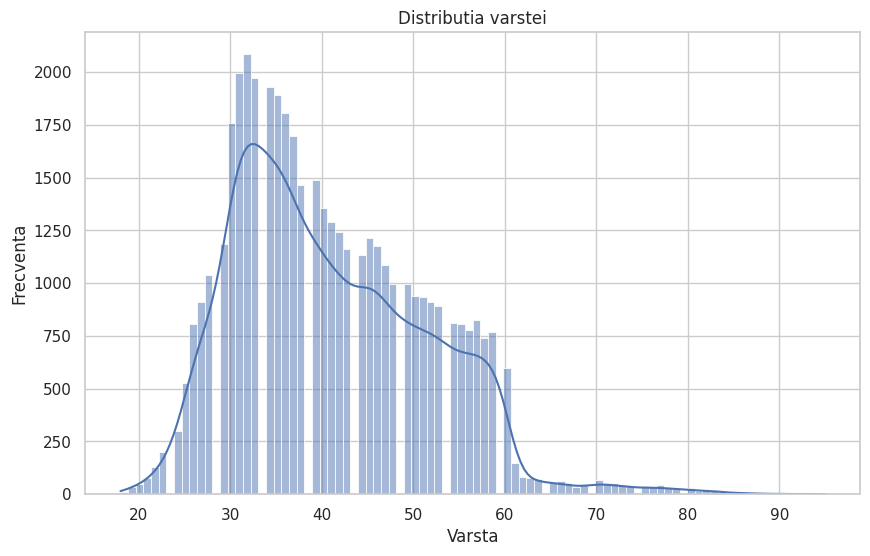

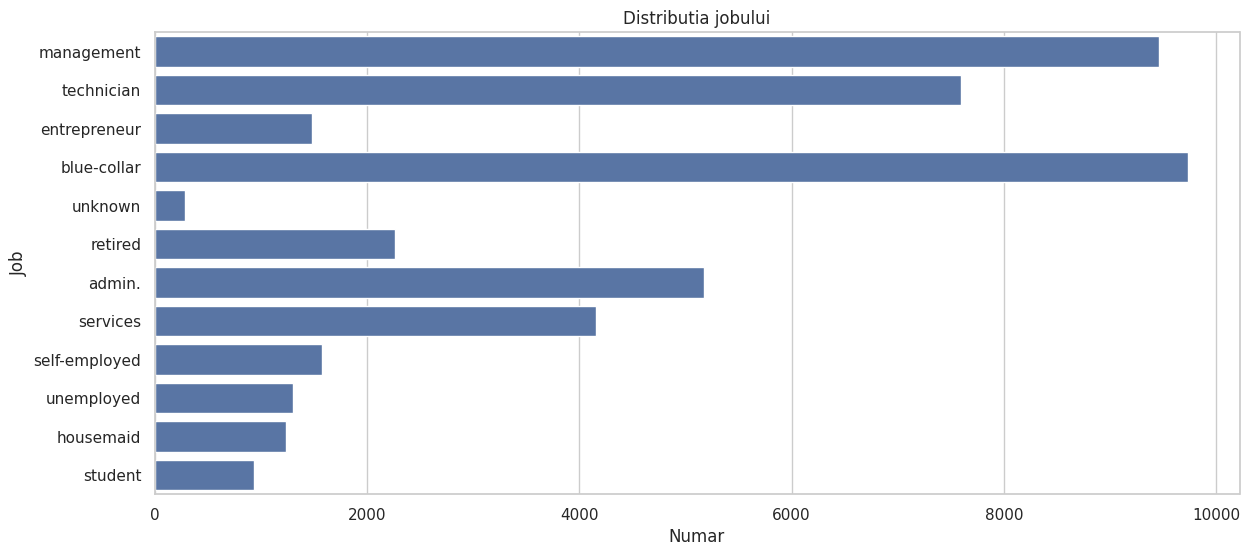

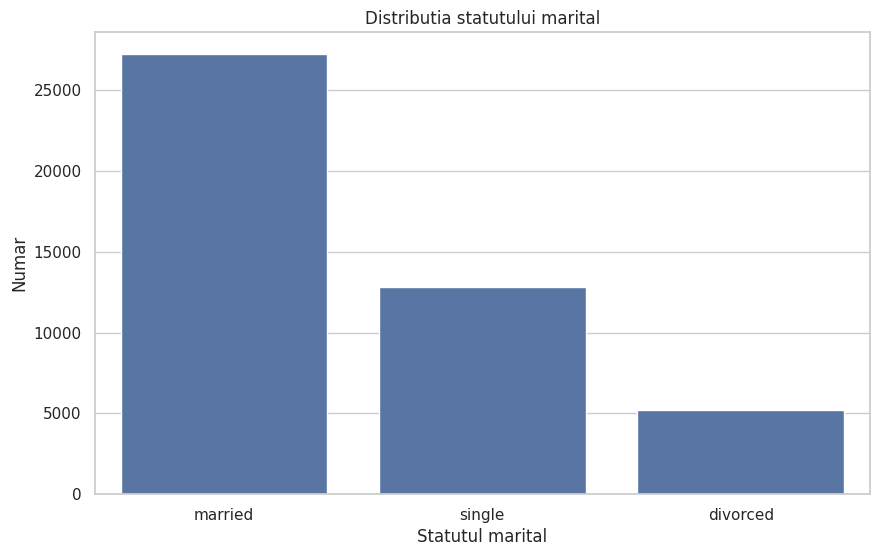

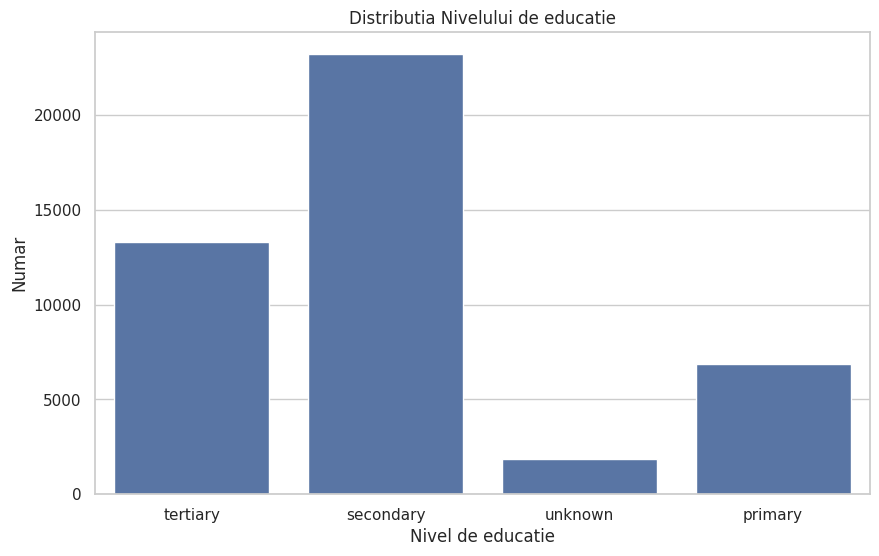

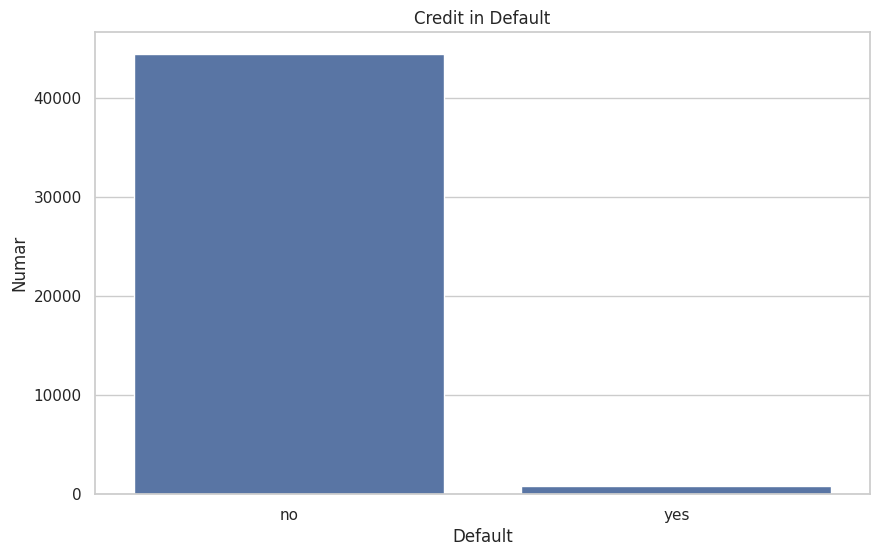

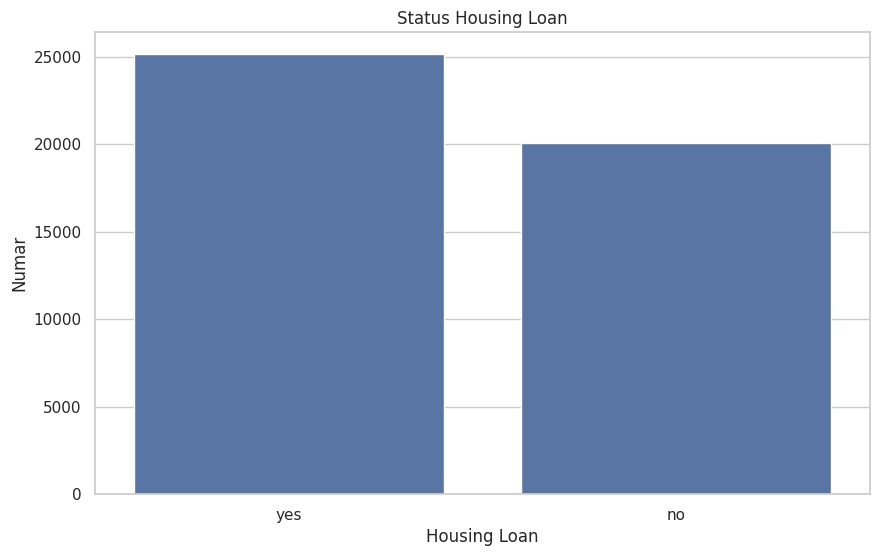

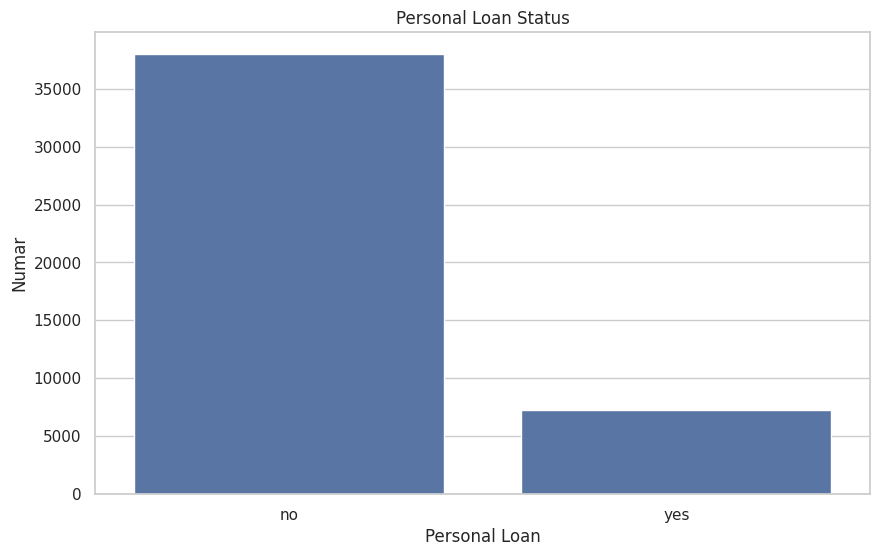

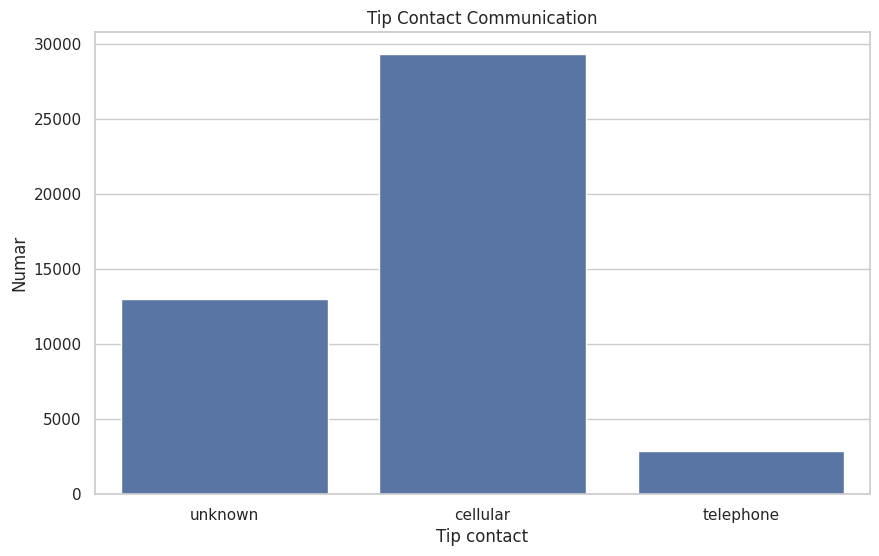

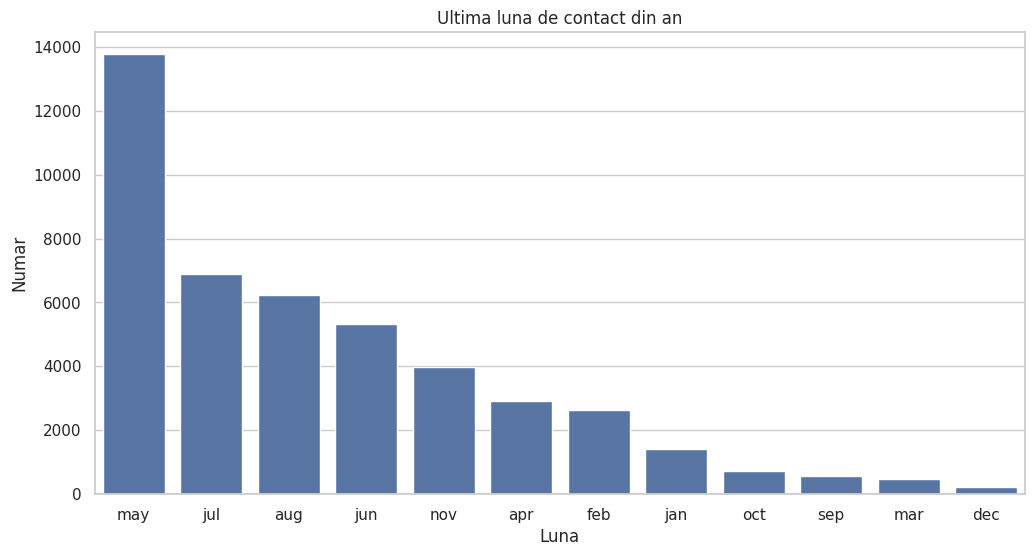

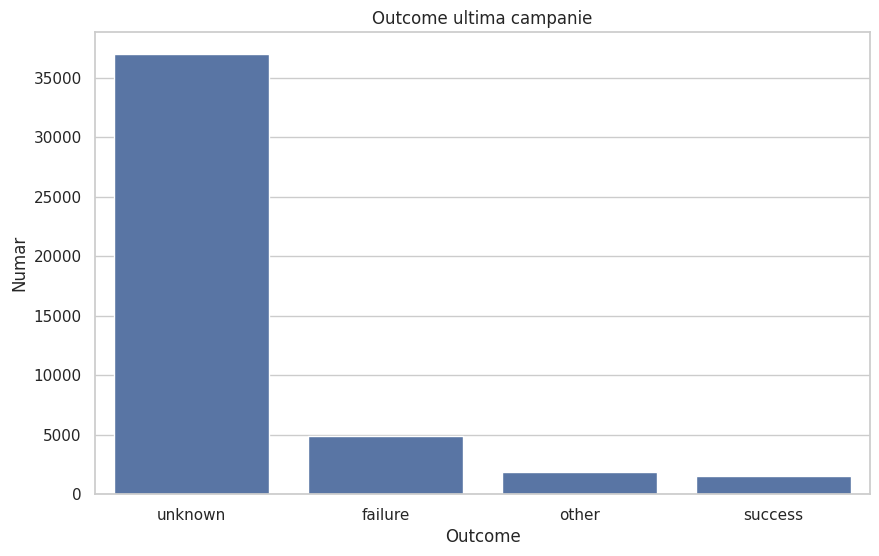

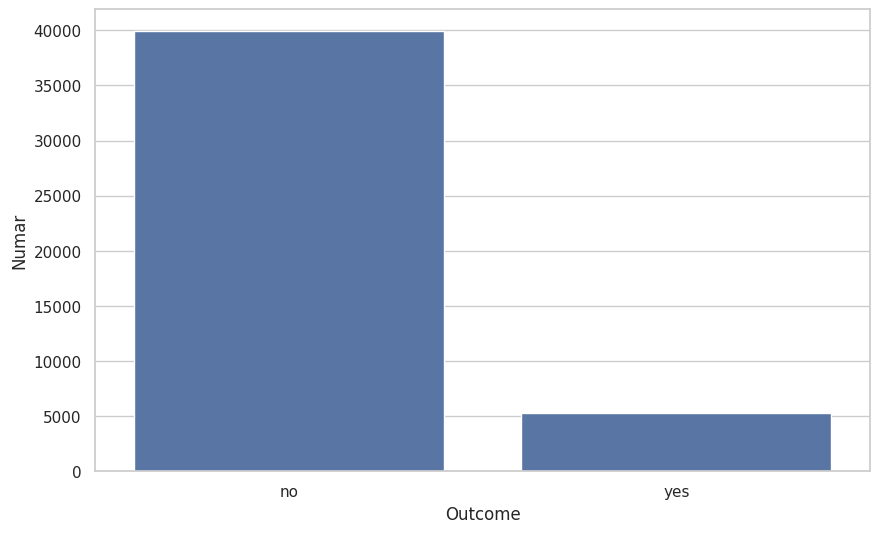

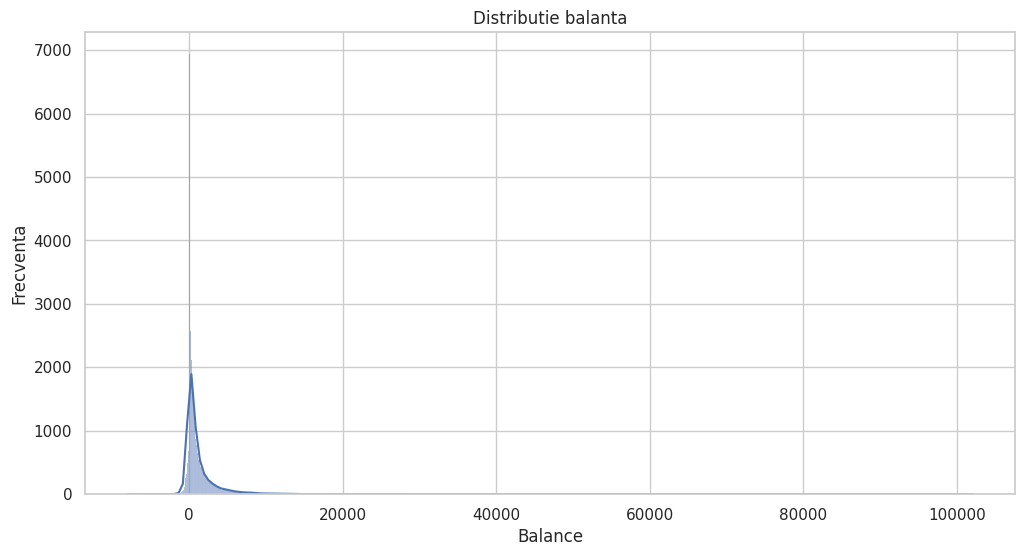

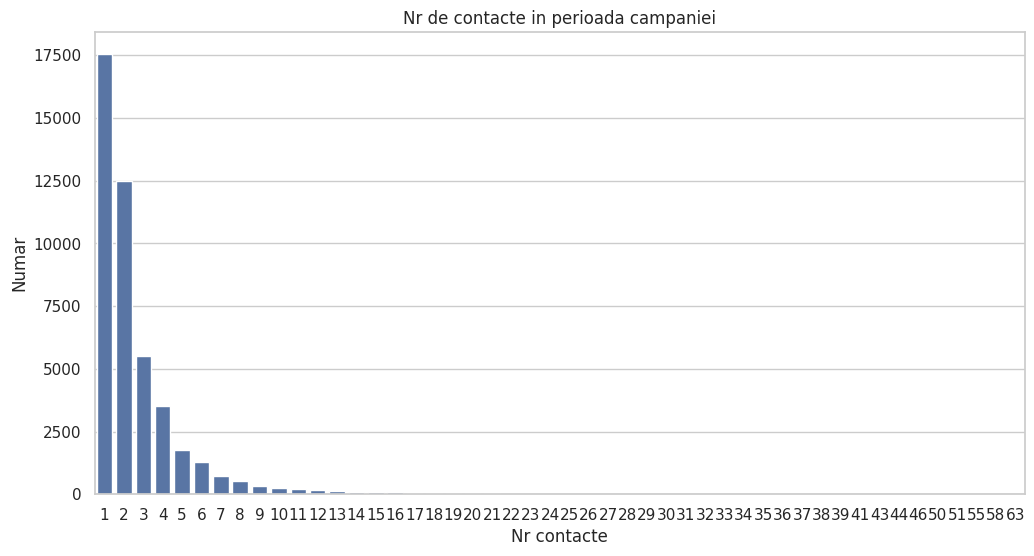

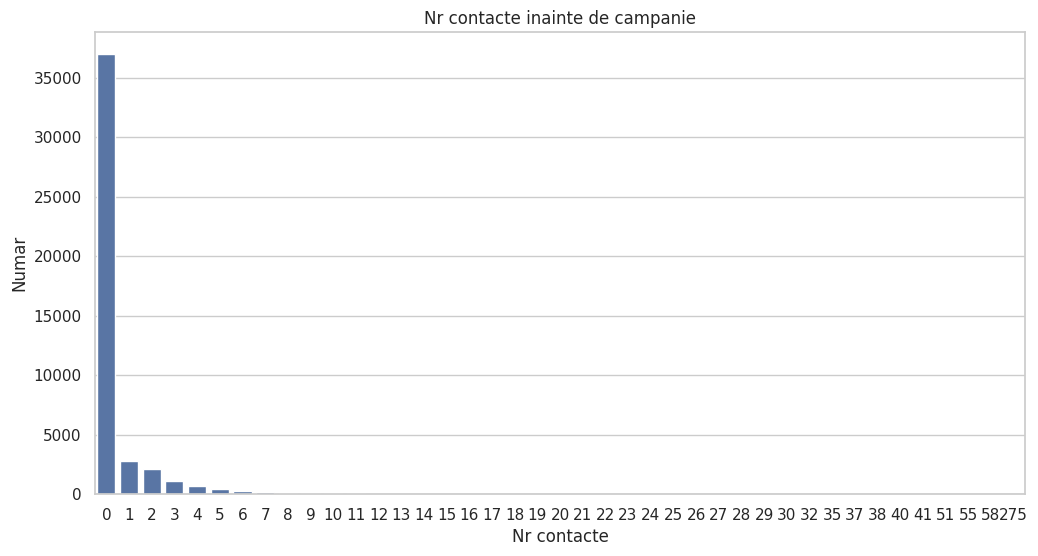

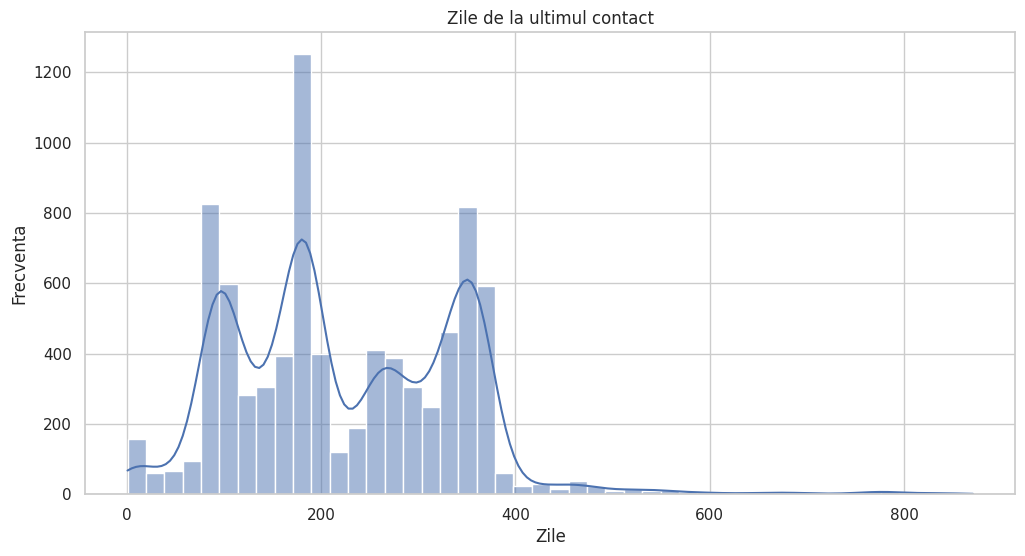

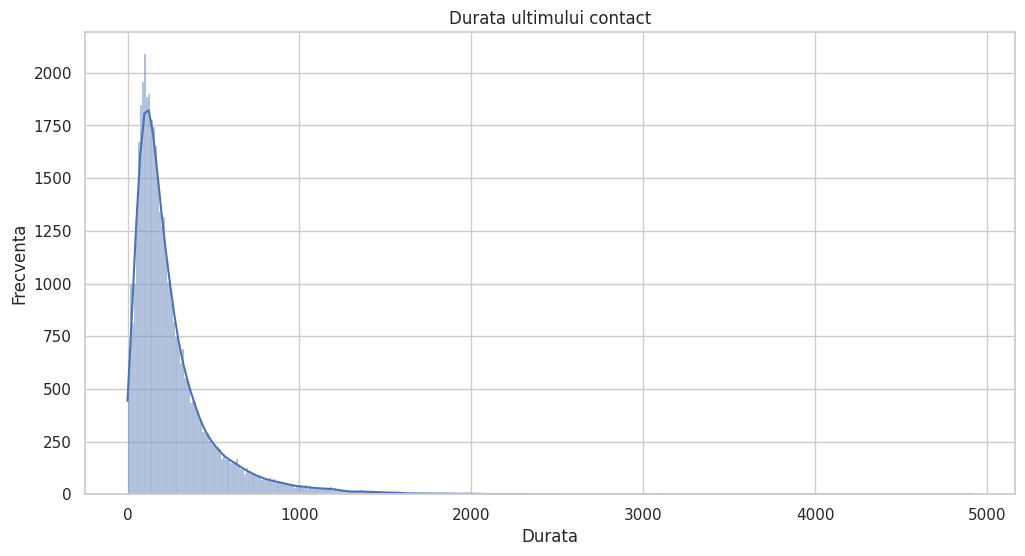

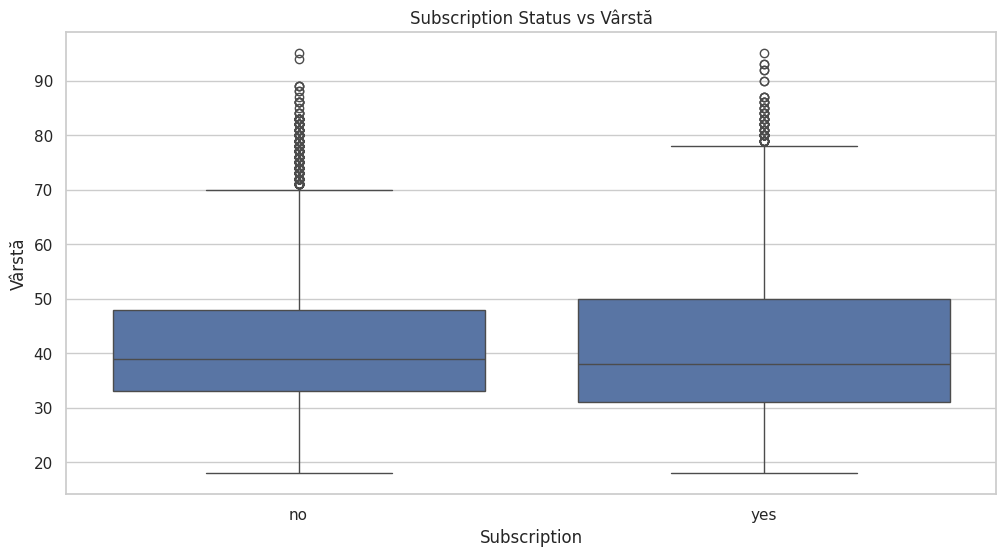

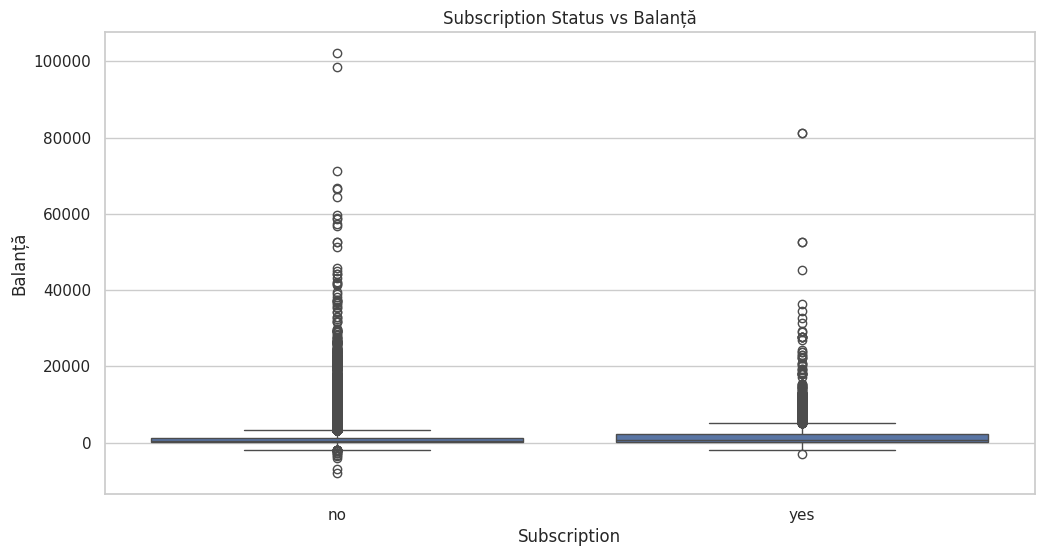

<ipython-input-96-02484449931e>:134: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)


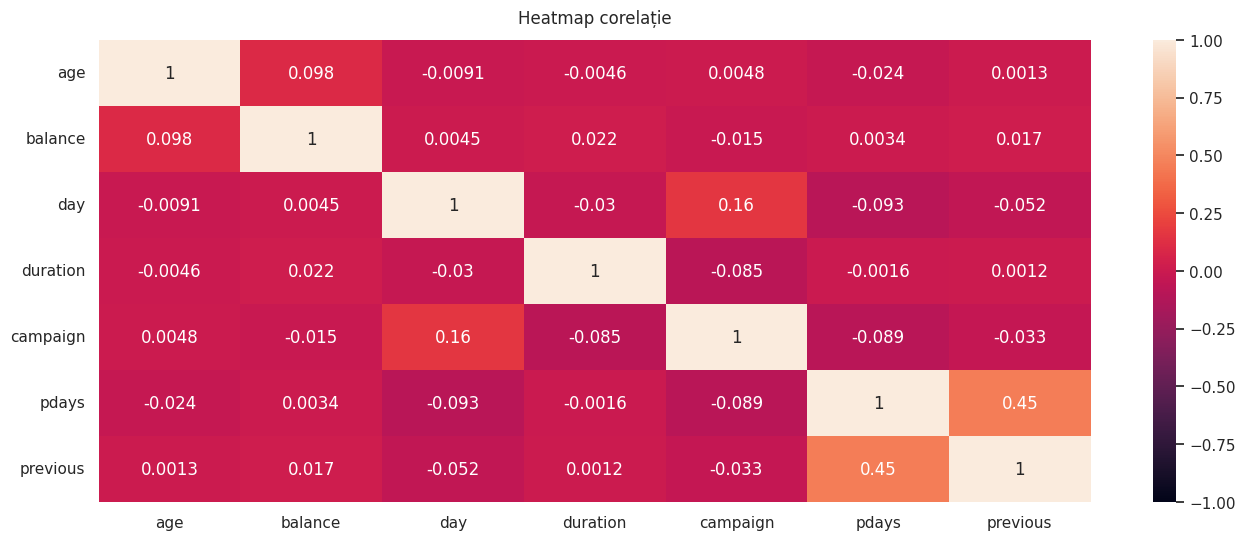

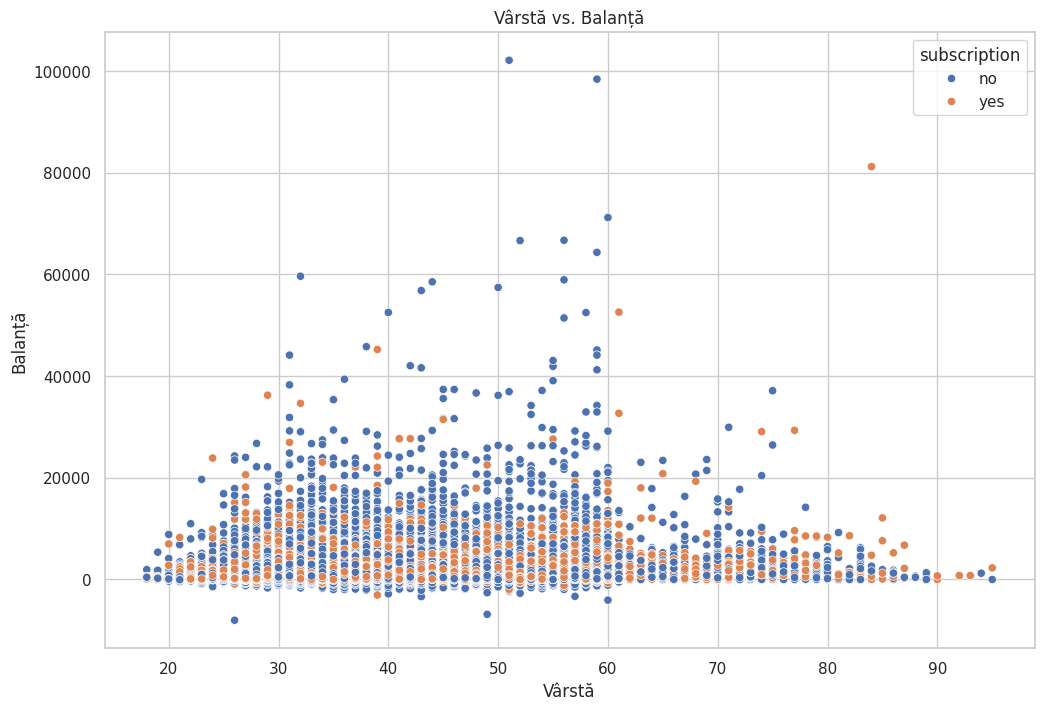

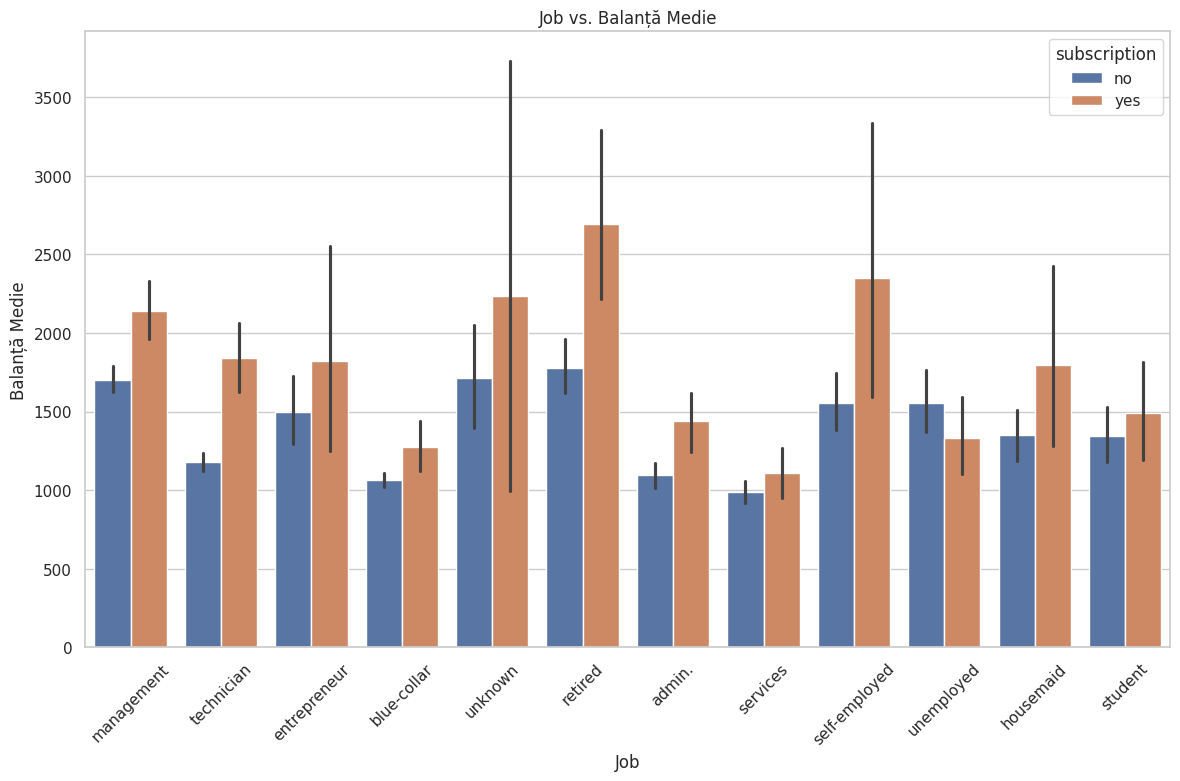

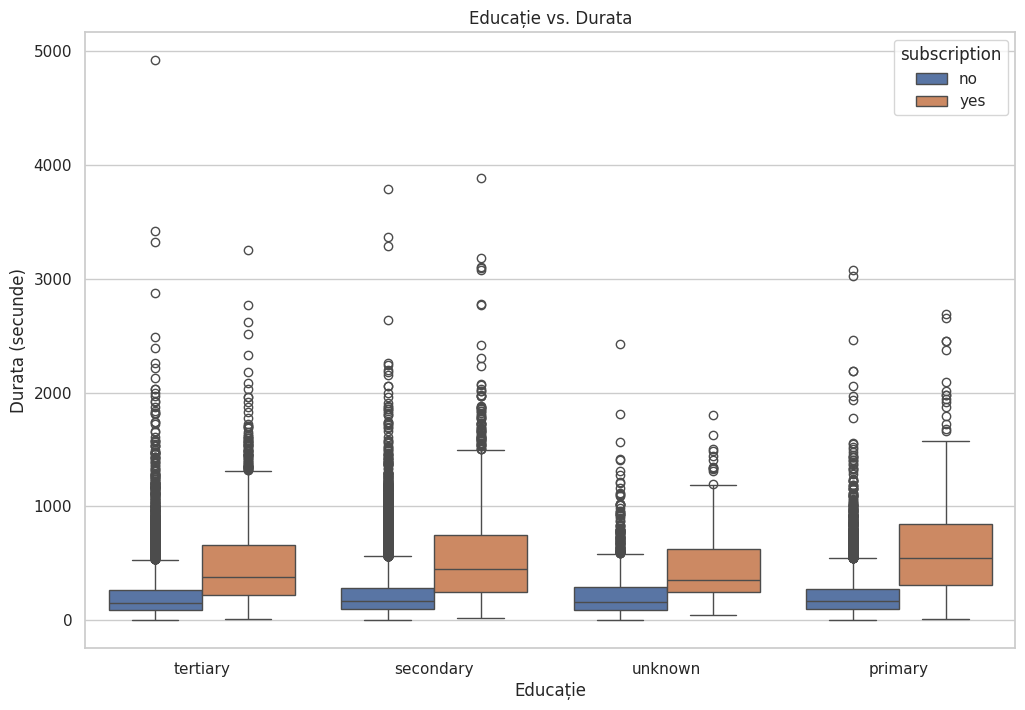

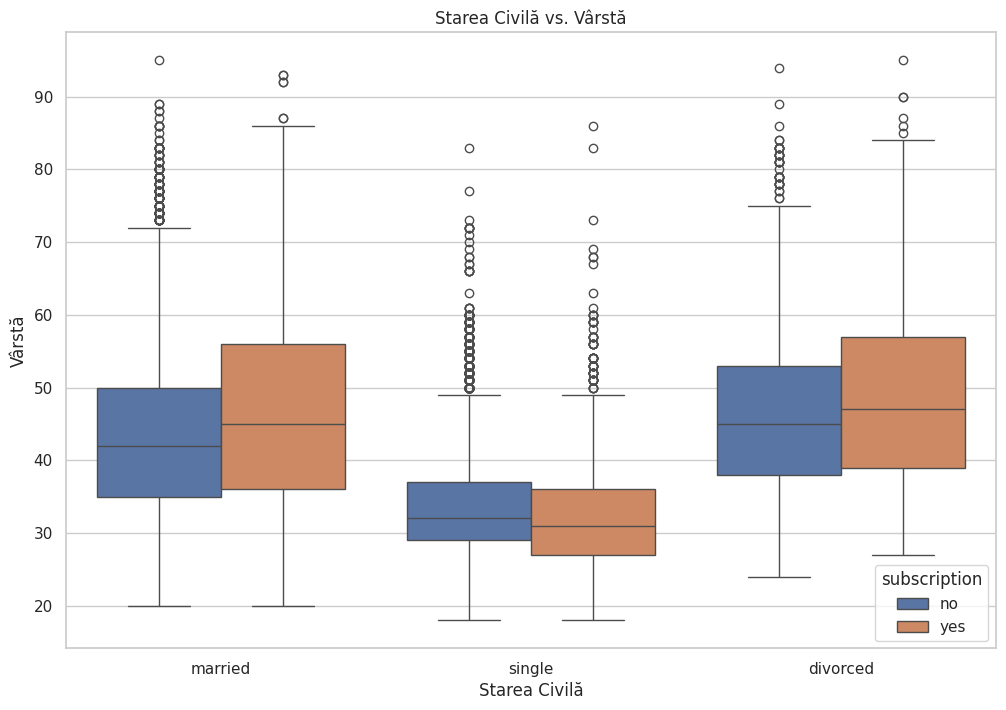

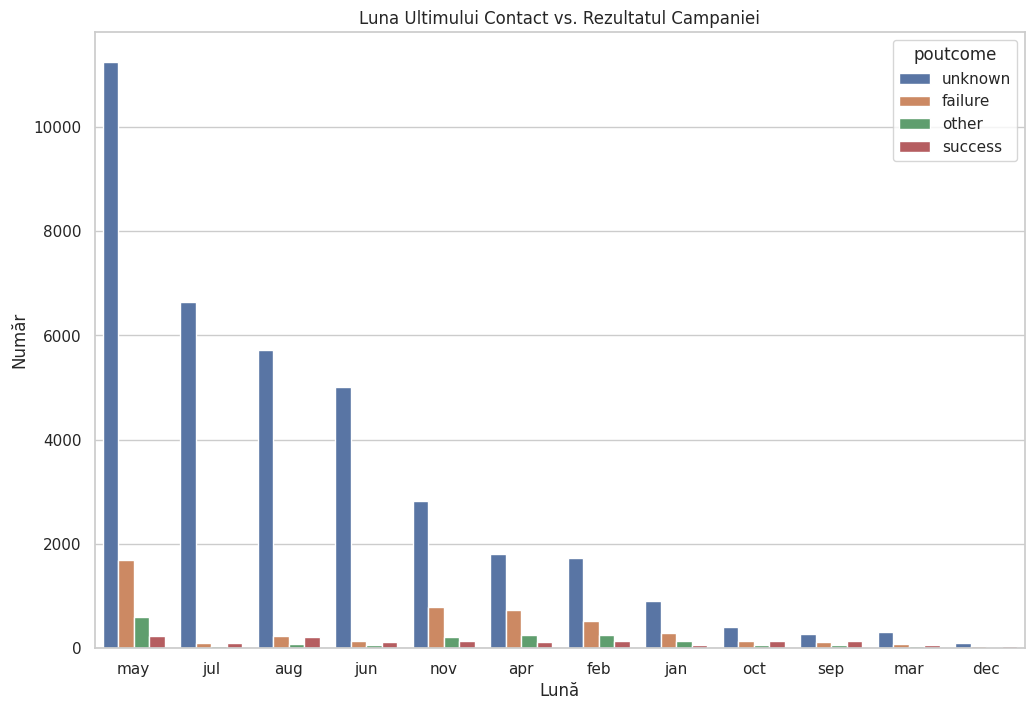

In [ ]:
data = pd.read_csv('data.csv')
sns.set(style="whitegrid")

# Info de bază
print(data.info())
print(data.head())

plt.figure(figsize=(10, 6))
sns.histplot(data['age'], kde=True)
plt.title('Distributia varstei')
plt.xlabel('Varsta')
plt.ylabel('Frecventa')
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(y='job', data=data)
plt.title('Distributia jobului')
plt.xlabel('Numar')
plt.ylabel('Job')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='marital', data=data)
plt.title('Distributia statutului marital')
plt.xlabel('Statutul marital')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='education', data=data)
plt.title('Distributia Nivelului de educatie')
plt.xlabel('Nivel de educatie')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='default', data=data)
plt.title('Credit in Default')
plt.xlabel('Default')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='housing', data=data)
plt.title('Status Housing Loan')
plt.xlabel('Housing Loan')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='loan', data=data)
plt.title('Personal Loan Status')
plt.xlabel('Personal Loan')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='contact', data=data)
plt.title('Tip Contact Communication')
plt.xlabel('Tip contact')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='month', data=data, order = data['month'].value_counts().index)
plt.title('Ultima luna de contact din an')
plt.xlabel('Luna')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='poutcome', data=data)
plt.title('Outcome ultima campanie')
plt.xlabel('Outcome')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='subscription', data=data)
plt.xlabel('Outcome')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data['balance'], kde=True)
plt.title('Distributie balanta')
plt.xlabel('Balance')
plt.ylabel('Frecventa')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='campaign', data=data)
plt.title('Nr de contacte in perioada campaniei')
plt.xlabel('Nr contacte')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='previous', data=data)
plt.title('Nr contacte inainte de campanie')
plt.xlabel('Nr contacte')
plt.ylabel('Numar')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data[data['pdays'] != -1]['pdays'], kde=True)
plt.title('Zile de la ultimul contact')
plt.xlabel('Zile')
plt.ylabel('Frecventa')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data['duration'], kde=True)
plt.title('Durata ultimului contact')
plt.xlabel('Durata')
plt.ylabel('Frecventa')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='subscription', y='age', data=data)
plt.title('Subscription Status vs Vârstă')
plt.xlabel('Subscription')
plt.ylabel('Vârstă')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='subscription', y='balance', data=data)
plt.title('Subscription Status vs Balanță')
plt.xlabel('Subscription')
plt.ylabel('Balanță')
plt.show()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Heatmap corelație', fontdict={'fontsize':12}, pad=12);
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='balance', hue='subscription', data=data)
plt.title('Vârstă vs. Balanță')
plt.xlabel('Vârstă')
plt.ylabel('Balanță')
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='job', y='balance', hue='subscription', data=data, estimator=lambda x: sum(x) / len(x))
plt.xticks(rotation=45)
plt.title('Job vs. Balanță Medie')
plt.xlabel('Job')
plt.ylabel('Balanță Medie')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='education', y='duration', hue='subscription', data=data)
plt.title('Educație vs. Durata')
plt.xlabel('Educație')
plt.ylabel('Durata (secunde)')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='marital', y='age', hue='subscription', data=data)
plt.title('Starea Civilă vs. Vârstă')
plt.xlabel('Starea Civilă')
plt.ylabel('Vârstă')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(x='month', hue='poutcome', data=data, order = data['month'].value_counts().index)
plt.title('Luna Ultimului Contact vs. Rezultatul Campaniei')
plt.xlabel('Lună')
plt.ylabel('Număr')
plt.show()

In [ ]:
#NaN values

# Scoatem rândurile cu valori nan
# data_dropped_rows = data.dropna()

# Scoatem coloanele cu valori NaN
# data_dropped_columns = data.dropna(axis=1)


# Umplem valorile nan cu media
# mean_imputer = SimpleImputer(strategy='mean')
# df_mean_imputed = data.copy()
# df_mean_imputed.iloc[:, :] = mean_imputer.fit_transform(df_mean_imputed)

# Umplem valorile nan cu mediana
# median_imputer = SimpleImputer(strategy='median')
# df_median_imputed = data.copy()
# df_median_imputed.iloc[:, :] = median_imputer.fit_transform(df_median_imputed)


# Umplem valorile categorice nan cu mode-ul
# mode_imputer = SimpleImputer(strategy='most_frequent')
# df_mode_imputed = data.copy()
# df_mode_imputed.iloc[:, :] = mode_imputer.fit_transform(df_mode_imputed)

# imputer = KNNImputer(n_neighbors=5)

# df_imputed_knn = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [ ]:
# data = pd.get_dummies(data, columns=['job','marital','education','default','housing','loan','contact','month','poutcome'], drop_first=True)

In [ ]:
data = pd.read_csv('data.csv')


#Fara valori nan
data.isnull().sum().sum()


0

In [ ]:
label_encoder = LabelEncoder()

data['subscription'] = label_encoder.fit_transform(data['subscription'])
data['subscription']

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: subscription, Length: 45211, dtype: int64

In [ ]:
numerical_data = data.select_dtypes(include=['number'])


iso_forest = IsolationForest().fit_predict(numerical_data)
ell_env = EllipticEnvelope().fit_predict(numerical_data)
lof = LocalOutlierFactor(n_neighbors=20).fit_predict(numerical_data)
# one_class_svm = OneClassSVM(gamma='auto', nu=0.01).fit_predict(data)

# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# sns.scatterplot(x=numerical_data[0, 0], y=numerical_data[0, 1], hue=iso_forest, ax=axes[0, 0])
# axes[0, 0].set_title('Isolation Forest')

# sns.scatterplot(x=numerical_data[:, 0], y=numerical_data[:, 1], hue=ell_env, ax=axes[0, 1])
# axes[0, 1].set_title('Elliptic Envelope')

# sns.scatterplot(x=numerical_data[:, 0], y=numerical_data[:, 1], hue=lof, ax=axes[1, 0])
# axes[1, 0].set_title('Local Outlier Factor')

# sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=one_class_svm, ax=axes[1, 1])
# axes[1, 1].set_title('One-Class SVM')

# plt.tight_layout()
# plt.show()

outlier_counts = {
    "IsolationForest": np.sum(iso_forest == -1),
    "EllipticEnvelope": np.sum(ell_env == -1),
    "LocalOutlierFactor": np.sum(lof == -1),
    # "OneClassSVM": np.sum(one_class_svm == -1)
}

outlier_counts

{'IsolationForest': 7513, 'EllipticEnvelope': 4521, 'LocalOutlierFactor': 808}

In [ ]:
#Fara imputari, nu avem valori nan

# def evaluate_imputation(imputer, X, y):
#     X_imputed = imputer.fit_transform(X)
#     model = LinearRegression()
#     model.fit(X_imputed, y)
#     y_pred = model.predict(X_imputed)
#     mse = mean_squared_error(y, y_pred)
#     r2 = r2_score(y, y_pred)
#     return mse, r2

In [ ]:
# Features pentru imputation
# numerical_data = data.select_dtypes(include=['number']).drop(['subscription'], axis=1)

# imputers = {
#     "Mean Imputation": SimpleImputer(strategy='mean'),
#     "Median Imputation": SimpleImputer(strategy='median'),
#     "KNN Imputation": KNNImputer(n_neighbors=5),
#     "MICE Imputation": IterativeImputer(estimator=RandomForestRegressor(), random_state=0)
# }

In [ ]:
# Evaluăm separat fiecare metodă de imputation
# imputation_results = {}
# for name, imputer in imputers.items():
#     mse, r2 = evaluate_imputation(imputer, numerical_data, y)
#     imputation_results[name] = (mse, r2)

# Afișăm rezultatele pentru fiecare metodă de imputation separat
# for method, (mse, r2) in imputation_results.items():
#     print(f"{method}: Mean Squared Error = {mse}, R-squared Scor = {r2}")

In [ ]:
X = data.drop('subscription', axis=1)
y = data['subscription']

In [ ]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "AdaBoost": AdaBoostClassifier(random_state=0),
    "SVC": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

In [ ]:
feature_selection_methods = {
    'F_Regression': SelectKBest(score_func=f_regression, k=15),
    'RFE': RFE(estimator=RandomForestClassifier(), n_features_to_select=15)
}

In [ ]:
# @title
param_grids = {
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga']
    },
    'Ridge Classifier': {
        'model__alpha': [0.1, 1, 10, 100],
        'model__solver': ['auto', 'sag', 'saga']
    },
    'Random Forest': {
        'model__n_estimators': [10, 50, 100, 200],
        'model__max_features': ['auto', 'sqrt', 'log2'],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 1]
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf', 'poly'],
        'model__gamma': ['scale', 'auto']
    },
    'K-Nearest Neighbors': {
        'model__n_neighbors': [3, 5, 7, 11],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

In [ ]:
# @title
model_performance = {}

best_estimators_with_feature_selection = {}
for fs_name, fs_method in feature_selection_methods.items():
    for model_name, model_params in param_grids.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('feature_selection', fs_method),
            ('model', models[model_name])
        ])

        grid_search = GridSearchCV(pipeline, param_grid=model_params, cv=5, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        best_estimators_with_feature_selection[f"{fs_name}_{model_name}"] = grid_search.best_estimator_
        print(f"Cei mai buni parametri pentru {model_name} cu {fs_name}: {grid_search.best_params_}")
        print(f"Cel mai bun accuracy score pentru {model_name} cu {fs_name}: {grid_search.best_score_}")
        # pipeline.fit(X_train, y_train)
        # y_pred = pipeline.predict(X_test)

# best_estimators_with_feature_selection
# for model_name, model in models.items():
#     model_pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
#         ('model', model)
#     ])
#     model_pipeline.fit(X_train, y_train)
#     y_pred = model_pipeline.predict(X_test)
#     model_performance[model_name] = r2_score(y_test, y_pred)

Cei mai buni parametri pentru Logistic Regression cu F_Regression: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Cel mai bun accuracy score pentru Logistic Regression cu F_Regression: 0.9025658402735198
Cei mai buni parametri pentru Ridge Classifier cu F_Regression: {'model__alpha': 0.1, 'model__solver': 'auto'}
Cel mai bun accuracy score pentru Ridge Classifier cu F_Regression: 0.8995244586172927


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Cei mai buni parametri pentru Random Forest cu F_Regression: {'model__max_depth': 10, 'model__max_features': 'auto', 'model__n_estimators': 200}
Cel mai bun accuracy score pentru Random Forest cu F_Regression: 0.9043353159598085
Cei mai buni parametri pentru Gradient Boosting cu F_Regression: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50}
Cel mai bun accuracy score pentru Gradient Boosting cu F_Regression: 0.9050265461870094
Cei mai buni parametri pentru AdaBoost cu F_Regression: {'model__learning_rate': 1, 'model__n_estimators': 200}
Cel mai bun accuracy score pentru AdaBoost cu F_Regression: 0.9023170382146676
Cei mai buni parametri pentru SVC cu F_Regression: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Cel mai bun accuracy score pentru SVC cu F_Regression: 0.9029529051962519
Cei mai buni parametri pentru K-Nearest Neighbors cu F_Regression: {'model__metric': 'euclidean', 'model__n_neighbors': 11, 'model__weights': 'uniform'}
Cel

In [ ]:
# r2_scores = {}

# for name, estimator in best_estimators_with_feature_selection.items():
#     y_pred = estimator.predict(X_test)
#     r2_scores[name] = r2_score(y_test, y_pred)
#     print(f"R2 Score pentru {name}: {r2_scores[name]}")